In [1]:
# Eng/Amr Mostafa Omar
# Nile University ,Cairo, Egypt
# Data 1/5/2024

##**The methodology used in this project involves several steps:**

**1. Reading SDF Files:** The project begins by defining a function read_sdf that reads an SDF (Structure Data File) containing information about chemical compounds. This involves parsing the file to extract data such as atom positions, connections, and other molecular properties.

**2. Data Preprocessing:** After reading the SDF file, we preprocesses the data. This includes tokenization, where chemical compounds are represented as sequences of tokens. Padding is then applied to ensure that all sequences have the same length for batch processing.

**3. Batch Generation:** Then we generates batches of data for training and validation. This step is crucial for efficient processing in machine learning models, especially when dealing with large datasets.

**4. Model Training and Evaluation**: we  trained  and evaluated machine learning models using TensorFlow. we defined the model architecture, specifies the optimizer (Adam with adjusted learning rates), and applied techniques like dropout regularization and batch normalization to improve model performance.

**5. Saving Predictions:** Finally, we saved the predictions made by the trained models to CSV files.

##**1.Problem Definition:**



**Input**:

Graph representations of chemical compounds in SDF format, where nodes are atoms and edges are bonds.
Labels indicating whether each compound is positive (1) or negative (0) for anti-cancer activity against non-small cell lung cancer.

**Output**:

Binary classification labels (1 for positive, 0 for negative) predicting the anti-cancer activity of each compound.

**Data Mining Function:**

The required data mining function is classification, specifically binary classification. This involves building a predictive model that learns patterns from the graph structures of chemical compounds to classify them as either positive or negative for anti-cancer activity.

**Challenges**:

**1. Graph Representation:**

Handling graph-structured data requires specialized techniques such as Graph Neural Networks (GNNs) to effectively capture the structural information.

**2. Data Complexity:**

Chemical compound graphs can be complex and diverse, requiring robust models capable of generalizing well.

**3. Class Imbalance:**

The dataset  have an imbalance between positive and negative compounds, which can impact model training and evaluation.

**4. Feature Engineering:**

Extracting meaningful features from graph structures and encoding them appropriately for machine learning models is non-trivial.

**5. Model Interpretability:**

Interpreting the decisions of complex models like GNNs can be challenging, especially in domains like healthcare where interpretability is crucial.


**Impact:**
The impact of successfully solving this problem is significant in the field of medicine and pharmaceuticals. Accurate prediction of anti-cancer activity can expedite drug discovery processes, reduce costs, and lead to the development of more effective treatments for non-small cell lung cancer patients.

In [2]:
#Installing some libiraries
!pip install tf2_gnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 860.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.5/394.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.1/166.1 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.4/193.4 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.7 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=00ffa5b0bdab5616867c9bb0d3f8288ad6344cce1df9f1c3f22cd6fe1f6c9a71
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [3]:
# Import  libraries
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tf2_gnn.layers.gnn import GNN, GNNInput
from tensorflow.keras.layers import Embedding, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.math import segment_mean
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_auc_score
import random
import math

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [4]:
# Mount Google Drive to access files
from google.colab import drive

In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# File path to your SDF file
file_path_train = '/content/gdrive/MyDrive/train.sdf'
file_path_test = '/content/gdrive/MyDrive/test_x.sdf'

##**2-Data Loading:**

In [7]:
# Read the SDF files and preprocess the data
def read_sdf(file):
    with open(file, 'r') as rf:
        content = rf.read()
    samples = content.split('$$$$')
    def parse_sample(s):
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0
        for l in lines:
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):
                lnk = l.split()
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0]) - 1,
                        int(lnk[1]) - 1,
                    ))
        return nodes, np.array(links), label
    return [parse_sample(s) for s in samples if len(s[0]) > 0]

In [8]:
# Read train and test data
train_data = read_sdf(file_path_train)
test_data = read_sdf(file_path_test)

## **Split data into training and validation set**

In [9]:
# Split the data into train and validation sets
train_set, validation_set = train_test_split(train_data, test_size=0.2, random_state=35)

###**Exploration of  dataset**

In [10]:
# Print a sample from the training set
print(train_set[0])

(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0,  8],
       [ 0,  9],
       [ 1, 10],
       [11,  2],
       [ 3, 15],
       [ 4, 16],
       [ 5, 19],
       [ 6, 20],
       [ 7,  9],
       [ 7, 10],
       [ 7, 13],
       [ 8, 11],
       [ 8, 12],
       [ 9, 14],
       [10, 11],
       [12, 17],
       [12, 18],
       [13, 15],
       [14, 16],
       [15, 16],
       [17, 19],
       [18, 21],
       [19, 20],
       [20, 21]]), 0)


In [ ]:
 # Convert training set to DataFrame for analysis
df_train = pd.DataFrame(train_set, columns=['Nodes', 'Edges', 'Label'])

In [ ]:
# Get insights about the dataset
num_samples = len(df_train)
class_distribution = df_train['Label'].value_counts()
num_positive_samples = class_distribution[1]
num_negative_samples = class_distribution[0]

In [ ]:
print('num_samples is ',num_samples)

num_samples is  20019


In [ ]:
print('distribution of classes as the following ',class_distribution)

distribution of classes as the following  Label
0    19018
1     1001
Name: count, dtype: int64


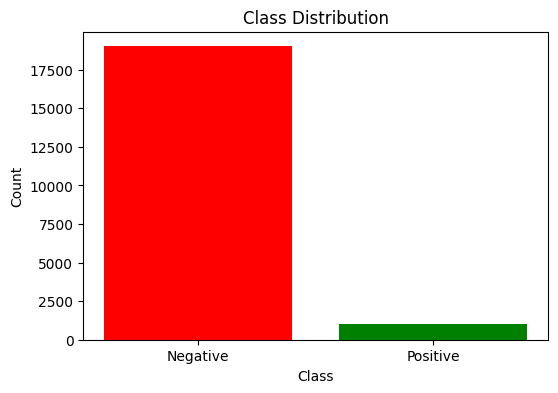

In [ ]:
# Plot class distribution
plt.figure(figsize=(6, 4))
plt.bar(['Negative', 'Positive'], [num_negative_samples, num_positive_samples], color=['red', 'green'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()



`This unbalanced bar graph shows a class distribution. Red bars (negative) are outnumbered by green (positive class). This imbalance can affect machine learning models, favoring the more frequent negative class.`

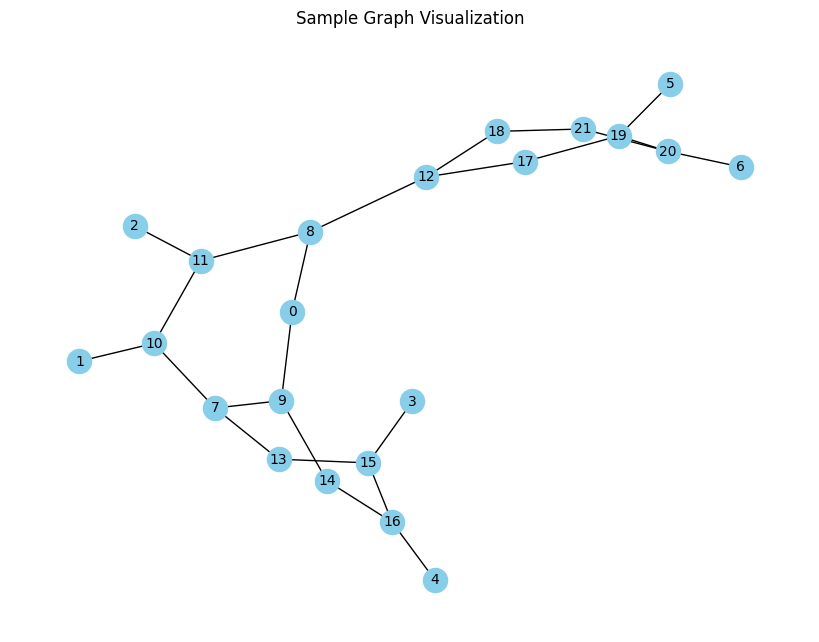

In [ ]:
# Visualize a sample graph from the dataset
sample_graph = df_train.loc[0, 'Edges']
G = nx.Graph()
G.add_edges_from(sample_graph)
pos = nx.spring_layout(G)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='black', linewidths=1, font_size=10)
plt.title('Sample Graph Visualization')
plt.show()

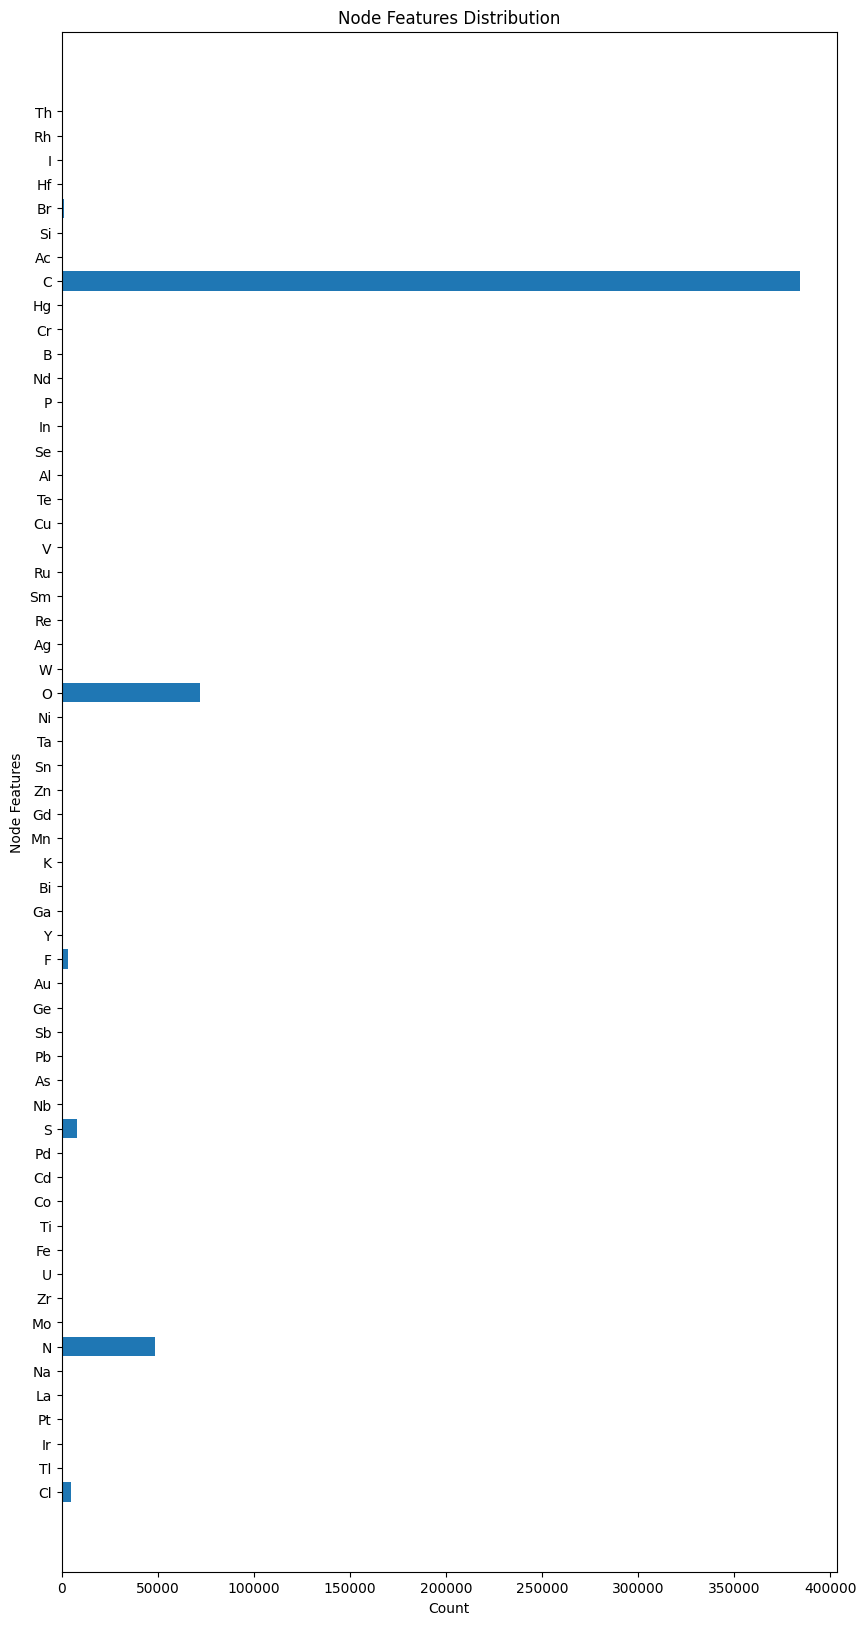

In [ ]:
# Calculate and plot the distribution of node features
all_nodes = [node for nodes, _, _ in train_set for node in nodes]
unique_nodes = set(all_nodes)
node_counts = {node: all_nodes.count(node) for node in unique_nodes}

plt.figure(figsize=(10, 20))
plt.barh(list(node_counts.keys()), list(node_counts.values()))
plt.xlabel('Count')
plt.ylabel('Node Features')
plt.title('Node Features Distribution')
plt.show()

`This plot the shows the distribution of node features and illusterate the numbers of each chemical elements that exist in different chemical compounds`

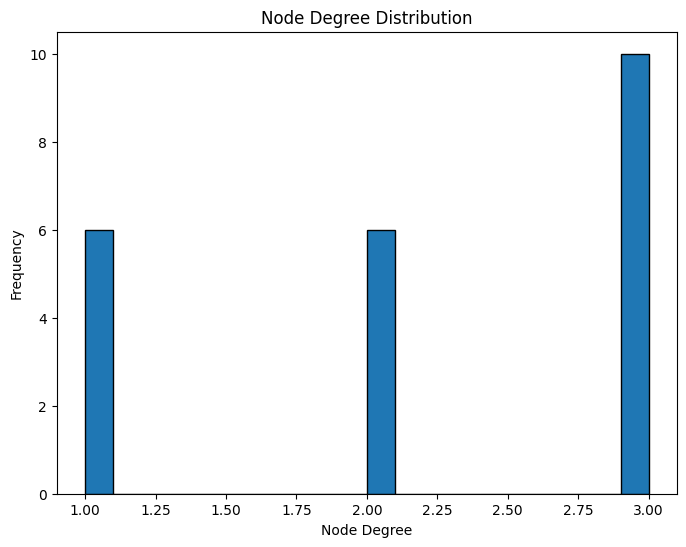

In [ ]:
# Calculate node degrees and plot their distribution
node_degrees = dict(G.degree())
plt.figure(figsize=(8, 6))
plt.hist(list(node_degrees.values()), bins=20, edgecolor='black')
plt.xlabel('Node Degree')
plt.ylabel('Frequency')
plt.title('Node Degree Distribution')
plt.show()

## **Data  Preprocessing**

In [11]:
# Define # Vocabulary size
max_vocab = 500
max_len = 100

In [12]:
# build vocabulary from training set
all_nodes = [s[0] for s in train_set]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [13]:
def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples]
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    max_nodes_len = np.shape(sample_nodes)[1]

    edges = [s[1] + i * max_nodes_len for i, s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]

    node_to_graph = [[i] * max_nodes_len for i in range(len(samples))]

    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)

    node_to_graph = np.reshape(node_to_graph, -1)

    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])

In [14]:
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break

In [15]:
for train_batch in gen_batch(train_set, batch_size=4):
    for k, v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

data
[2 2 2 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 4 2 2 2 3 3 3
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 3 3 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 2 2 2 2 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]
edges
[[  0  12]
 [  0  22]
 [  1  12]
 [  2  13]
 [  2  23]
 [  3  17]
 [  3  24]
 [  4   7]
 [  4   9]
 [  5   8]
 [  5  10]
 [  6   7]
 [  6  11]
 [  7   8]
 [  8  12]
 [  9  10]
 [  9  14]
 [ 10  15]
 [ 11  16]
 [ 11  18]
 [ 13  16]
 [ 13  17]
 [ 14  20]
 [ 15  21]
 [ 17  19]
 [ 18  19]
 [ 20  21]
 [ 22  25]
 [ 30  37]
 [ 30  38]
 [ 31  37]
 [ 32  40]
 [ 33  41]
 [ 34  35]
 [ 34  37]
 [ 34  39]
 [ 35  38]
 [ 36  38]
 [ 39  40]
 [ 40  41]
 [ 60  69]
 [ 60  79]
 [ 61  69]
 [ 62  68]
 [ 62  72]
 [ 62  73]
 [ 63  66]
 [ 63  71]
 [ 64  65]
 [ 64  66]
 [ 64  67]
 [ 65  68]
 [ 65  70]
 [ 66  69]
 [ 67  71]
 [ 67  74]
 [ 70  72]
 [ 73  75]
 [ 73  76]
 [ 75  77]
 [ 76  78]
 [ 77  80]
 [ 78  80]
 [ 79  81]
 [ 90 108]
 [ 91 109]
 [ 92 110]
 [ 93 1

In [16]:
import tensorflow as tf
from tensorflow import keras

In [17]:
batch_size = 16
num_batchs = math.ceil(len(train_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

In [18]:
# Define GNNInput, tokenizer, and other necessary variables

data = keras.Input(batch_shape=(None,))
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 60)(data)
num_graph = tf.reduce_max(node2graph)+1

In [19]:
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph,
    num_graphs=num_graph,
)

##**Expectation :Trial 1**

As a baseline, Trial 1 sets initial performance expectations. Subsequent trials will be compared to its accuracy to assess improvements

##**Trial 1**: Baseline model with mean aggregation and no up-sampling

In [20]:
params_attempt_1 = GNN.get_default_hyperparameters()
params_attempt_1["hidden_dim"] = 32
params_attempt_1["message_calculation_class"] = "GGNN"

gnn_layer_attempt_1 = GNN(params_attempt_1)

gnn_out_attempt_1 = gnn_layer_attempt_1(gnn_input)

avg_attempt_1 = segment_mean(data=gnn_out_attempt_1, segment_ids=node2graph)

pred_attempt_1 = Dense(1, activation='sigmoid')(avg_attempt_1)

model_attempt_1 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred_attempt_1
)

In [ ]:
model_attempt_1.compile(
    optimizer=Adam(),
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
history_attempt_1 = model_attempt_1.fit(
    gen_batch(train_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(validation_set, batch_size=batch_size, repeat=True),
    validation_steps=num_batchs_validation,
)

Epoch 1/10
1252/1252 [==============================] - 39s 31ms/step - loss: 0.1882 - auc: 0.6683 - val_loss: 0.1716 - val_auc: 0.6838
Epoch 2/10
1252/1252 [==============================] - 33s 26ms/step - loss: 0.1882 - auc: 0.6744 - val_loss: 0.1669 - val_auc: 0.7192
Epoch 3/10
1252/1252 [==============================] - 37s 30ms/step - loss: 0.1872 - auc: 0.6784 - val_loss: 0.1695 - val_auc: 0.7031
Epoch 4/10
1252/1252 [==============================] - 35s 28ms/step - loss: 0.1844 - auc: 0.6960 - val_loss: 0.1638 - val_auc: 0.7066
Epoch 5/10
1252/1252 [==============================] - 38s 31ms/step - loss: 0.1839 - auc: 0.6940 - val_loss: 0.1640 - val_auc: 0.7416
Epoch 6/10
1252/1252 [==============================] - 37s 29ms/step - loss: 0.1789 - auc: 0.7214 - val_loss: 0.1594 - val_auc: 0.7327
Epoch 7/10
1252/1252 [==============================] - 35s 28ms/step - loss: 0.1780 - auc: 0.7282 - val_loss: 0.1592 - val_auc: 0.7593
Epoch 8/10
1252/1252 [==========================

In [ ]:
# Generate predictions using the trained model
y_pred_trial_1 = model_attempt_1.predict(gen_batch(validation_set, batch_size=batch_size, repeat=False)).reshape(-1)

# Calculate AUROC
y_true_trial_1 = np.array([s[2] for s in validation_set])
auroc_trial_1 = roc_auc_score(y_true_trial_1, y_pred_trial_1)
print("AUROC for Trial 1:", auroc_trial_1)

313/313 [==============================] - 3s 10ms/step
AUROC for Trial 1: 0.49860923429926585


##**Prediction:**



In [ ]:
y_pred_1 = model_attempt_1.predict(gen_batch(test_data, batch_size=batch_size, shuffle=False))
y_pred_1 = np.reshape(y_pred_1, -1)

771/771 [==============================] - 17s 22ms/step


##**Save model:**


In [ ]:
submission_1 = pd.DataFrame({'label':y_pred_1})
submission_1.index.name = 'id'
submission_1.to_csv('trail_1.csv')

##**Observations:**

The AUROC of 0.4986 indicates poor model performance, suggesting the need for improvement in subsequent trials.


##**Expectation: Trial 2**

Implementing mean aggregation with up-sampling in Trial 2 aims to address class imbalance, likely improving accuracy compared to Trial 1 by providing better representation of the minority class.


##**Trial 2**: Mean aggregation with up-sampling of positive class samples

In [21]:
from sklearn.utils import resample

# Separate positive and negative samples
positive_samples = [sample for sample in train_set if sample[2] == 1]
negative_samples = [sample for sample in train_set if sample[2] == 0]

# Determine the size of the up-sampled positive class
num_positive_samples = len(positive_samples)
num_negative_samples = len(negative_samples)
desired_positive_samples = num_negative_samples  # Up-sample to match the negative class

# Up-sample the positive class
upsampled_positive = resample(positive_samples, replace=True, n_samples=desired_positive_samples, random_state=42)

# Combine up-sampled positive class with original negative class
train_set_upsampled = negative_samples + upsampled_positive

In [ ]:
# Define hyperparameters for the GNN model
params_attempt_2 = GNN.get_default_hyperparameters()
params_attempt_2["hidden_dim"] = 32
params_attempt_2["message_calculation_class"] = "GGNN"

# Initialize GNN layer with hyperparameters
gnn_layer_attempt_2 = GNN(params_attempt_2)
gnn_out_attempt_2 = gnn_layer_attempt_2(gnn_input)

# Calculate mean aggregation
avg_attempt_2 = segment_mean(data=gnn_out_attempt_2, segment_ids=node2graph)

# Predictions using Dense layer
pred_attempt_2 = Dense(1, activation='sigmoid')(avg_attempt_2)

In [ ]:
# Define the GNN model for Trial 2
model_attempt_2 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred_attempt_2
)

In [ ]:
# Compile the model
model_attempt_2.compile(
    optimizer=Adam(),
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
# Train the model with up-sampled data
history_attempt_2 = model_attempt_2.fit(
    gen_batch(train_set_upsampled, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(validation_set, batch_size=batch_size, repeat=True),
    validation_steps=num_batchs_validation,
)

Epoch 1/10
1252/1252 [==============================] - 46s 37ms/step - loss: 0.4579 - auc: 0.8665 - val_loss: 0.4216 - val_auc: 0.8224
Epoch 2/10
1252/1252 [==============================] - 44s 35ms/step - loss: 0.4366 - auc: 0.8795 - val_loss: 0.4768 - val_auc: 0.8055
Epoch 3/10
1252/1252 [==============================] - 44s 35ms/step - loss: 0.4208 - auc: 0.8888 - val_loss: 0.5222 - val_auc: 0.8078
Epoch 4/10
1252/1252 [==============================] - 43s 34ms/step - loss: 0.4211 - auc: 0.8887 - val_loss: 0.5070 - val_auc: 0.8175
Epoch 5/10
1252/1252 [==============================] - 43s 34ms/step - loss: 0.3985 - auc: 0.9007 - val_loss: 0.6270 - val_auc: 0.8240
Epoch 6/10
1252/1252 [==============================] - 44s 35ms/step - loss: 0.3841 - auc: 0.9082 - val_loss: 0.6028 - val_auc: 0.8153
Epoch 7/10
1252/1252 [==============================] - 46s 36ms/step - loss: 0.3712 - auc: 0.9143 - val_loss: 0.4833 - val_auc: 0.8270
Epoch 8/10
1252/1252 [==========================

In [ ]:
# Generate predictions using the trained model for validation set
y_pred_validation_attempt_2 = model_attempt_2.predict(gen_batch(validation_set, batch_size=batch_size, repeat=False)).reshape(-1)

313/313 [==============================] - 4s 11ms/step


In [ ]:
# Calculate AUROC for validation set
y_true_validation = np.array([s[2] for s in validation_set])
auroc_validation_attempt_2 = roc_auc_score(y_true_validation, y_pred_validation_attempt_2)
print(f"AUROC for Validation (Attempt 2): {auroc_validation_attempt_2}")

AUROC for Validation (Attempt 2): 0.5373552929943908


##**Prediction:**


In [ ]:
# Generate predictions for test data
y_pred_attempt_2 = model_attempt_2.predict(gen_batch(test_data, batch_size=batch_size, shuffle=False)).reshape(-1)

771/771 [==============================] - 17s 22ms/step


##**Save model:**


In [ ]:
# Save predictions to a CSV file
submission_attempt_2 = pd.DataFrame({'label': y_pred_attempt_2})
submission_attempt_2.index.name = 'id'
submission_attempt_2.to_csv('trail_2.csv')

##**Observations: Trial 2**

With an AUROC of 0.5374, Trial 2 shows a slight improvement over Trial 1, indicating that mean aggregation with up-sampling may help in better capturing class imbalances.


##**Expectation: Trial 3**

Trying max aggregation with up-sampling in Trial 3 explores another aggregation method. Accuracy might be similar to Trial 2 or slightly improved, offering insights into the effectiveness of different aggregation techniques.


##**Trial 3**: Max aggregation with up-sampling of positive class samples.

In [ ]:
# Define the segment_max function
def segment_max(data, segment_ids):
    return tf.math.segment_max(data, segment_ids)

In [ ]:
# Define hyperparameters for the GNN model
params_attempt_3 = GNN.get_default_hyperparameters()
params_attempt_3["hidden_dim"] = 32
params_attempt_3["message_calculation_class"] = "GGNN"

# Initialize GNN layer with hyperparameters
gnn_layer_attempt_3 = GNN(params_attempt_3)
gnn_out_attempt_3 = gnn_layer_attempt_3(gnn_input)

# Calculate max aggregation
max_attempt_3 = segment_max(data=gnn_out_attempt_3, segment_ids=node2graph)

# Predictions using Dense layer
pred_attempt_3 = Dense(1, activation='sigmoid')(max_attempt_3)

In [ ]:
# Define the GNN model for Trial 3
model_attempt_3 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred_attempt_3
)

In [ ]:
# Compile the model
model_attempt_3.compile(
    optimizer=Adam(),
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
# Train the model with up-sampled data
history_attempt_3 = model_attempt_3.fit(
    gen_batch(train_set_upsampled, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(validation_set, batch_size=batch_size, repeat=True),
    validation_steps=num_batchs_validation,
)

Epoch 1/10
1252/1252 [==============================] - 31s 19ms/step - loss: 0.5928 - auc: 0.7409 - val_loss: 0.5281 - val_auc: 0.7724
Epoch 2/10
1252/1252 [==============================] - 22s 17ms/step - loss: 0.5253 - auc: 0.8167 - val_loss: 0.4141 - val_auc: 0.8054
Epoch 3/10
1252/1252 [==============================] - 23s 18ms/step - loss: 0.4551 - auc: 0.8691 - val_loss: 0.3913 - val_auc: 0.8108
Epoch 4/10
1252/1252 [==============================] - 22s 18ms/step - loss: 0.4267 - auc: 0.8859 - val_loss: 0.4060 - val_auc: 0.8258
Epoch 5/10
1252/1252 [==============================] - 21s 17ms/step - loss: 0.3917 - auc: 0.9052 - val_loss: 0.4010 - val_auc: 0.8435
Epoch 6/10
1252/1252 [==============================] - 24s 19ms/step - loss: 0.3710 - auc: 0.9152 - val_loss: 0.3637 - val_auc: 0.8438
Epoch 7/10
1252/1252 [==============================] - 22s 18ms/step - loss: 0.3444 - auc: 0.9273 - val_loss: 0.3962 - val_auc: 0.8435
Epoch 8/10
1252/1252 [==========================

In [ ]:
# Generate predictions using the trained model for validation set
y_pred_validation_attempt_3 = model_attempt_3.predict(gen_batch(validation_set, batch_size=batch_size, repeat=False)).reshape(-1)

# Calculate AUROC for validation set
y_true_validation = np.array([s[2] for s in validation_set])
auroc_validation_attempt_3 = roc_auc_score(y_true_validation, y_pred_validation_attempt_3)
print(f"AUROC for Validation (Attempt 3): {auroc_validation_attempt_3}")

313/313 [==============================] - 3s 7ms/step
AUROC for Validation (Attempt 3): 0.475018190637885


##**Prediction:**


In [ ]:
# Generate predictions for test data
y_pred_attempt_3 = model_attempt_3.predict(gen_batch(test_data, batch_size=batch_size, shuffle=False)).reshape(-1)

771/771 [==============================] - 4s 5ms/step


##**Save model:**


In [ ]:
# Save predictions to a CSV file
submission_attempt_3 = pd.DataFrame({'label': y_pred_attempt_3})
submission_attempt_3.index.name = 'id'
submission_attempt_3.to_csv('trail_3.csv')

##**Observations: Trial 3**
However, Trial 3's AUROC of 0.4750 is lower than Trial 2, suggesting that max aggregation might not be as effective as mean aggregation in this context.

##**Expectation: Trial 4**

Testing sum aggregation with up-sampling in Trial 4 may provide comparable or slightly different accuracy compared to Trials 2 and 3, shedding light on the effectiveness of various aggregation techniques


##**Trial 4** : Sum aggregation with up-sampling of positive class samples.

In [ ]:
def segment_sum(data, segment_ids):
    return tf.math.segment_sum(data, segment_ids)

In [ ]:
# Define hyperparameters for the GNN model
params_attempt_4 = GNN.get_default_hyperparameters()
params_attempt_4["hidden_dim"] = 32
params_attempt_4["message_calculation_class"] = "GGNN"

# Initialize GNN layer with hyperparameters
gnn_layer_attempt_4 = GNN(params_attempt_4)
gnn_out_attempt_4 = gnn_layer_attempt_4(gnn_input)

# Calculate sum aggregation
sum_attempt_4 = segment_sum(data=gnn_out_attempt_4, segment_ids=node2graph)

# Predictions using Dense layer
pred_attempt_4 = Dense(1, activation='sigmoid')(sum_attempt_4)

In [ ]:
# Define the GNN model for Attempt 4
model_attempt_4 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred_attempt_4
)

In [ ]:
# Compile the model
model_attempt_4.compile(
    optimizer=Adam(),
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
# Train the model with up-sampled data
history_attempt_4 = model_attempt_4.fit(
    gen_batch(train_set_upsampled, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(validation_set, batch_size=batch_size, repeat=True),
    validation_steps=num_batchs_validation,
)

Epoch 1/10
1252/1252 [==============================] - 36s 24ms/step - loss: 0.6199 - auc: 0.7102 - val_loss: 0.6669 - val_auc: 0.7378
Epoch 2/10
1252/1252 [==============================] - 22s 18ms/step - loss: 0.5901 - auc: 0.7523 - val_loss: 0.5711 - val_auc: 0.7404
Epoch 3/10
1252/1252 [==============================] - 22s 18ms/step - loss: 0.5392 - auc: 0.8025 - val_loss: 0.5598 - val_auc: 0.7781
Epoch 4/10
1252/1252 [==============================] - 22s 18ms/step - loss: 0.5080 - auc: 0.8322 - val_loss: 0.5484 - val_auc: 0.8013
Epoch 5/10
1252/1252 [==============================] - 24s 19ms/step - loss: 0.4731 - auc: 0.8574 - val_loss: 0.4543 - val_auc: 0.8102
Epoch 6/10
1252/1252 [==============================] - 24s 19ms/step - loss: 0.4453 - auc: 0.8748 - val_loss: 0.3941 - val_auc: 0.8352
Epoch 7/10
1252/1252 [==============================] - 23s 19ms/step - loss: 0.4192 - auc: 0.8907 - val_loss: 0.4426 - val_auc: 0.8390
Epoch 8/10
1252/1252 [==========================

In [ ]:
# Generate predictions using the trained model for validation set
y_pred_validation_attempt_4 = model_attempt_4.predict(gen_batch(validation_set, batch_size=batch_size, repeat=False)).reshape(-1)

# Calculate AUROC for validation set
y_true_validation = np.array([s[2] for s in validation_set])
auroc_validation_attempt_4 = roc_auc_score(y_true_validation, y_pred_validation_attempt_4)
print(f"AUROC for Validation (Attempt 4): {auroc_validation_attempt_4}")

313/313 [==============================] - 2s 5ms/step
AUROC for Validation (Attempt 4): 0.4828931006471633


##**Prediction:**


In [ ]:
# Generate predictions for test data
y_pred_attempt_4 = model_attempt_4.predict(gen_batch(test_data, batch_size=batch_size, shuffle=False)).reshape(-1)

771/771 [==============================] - 4s 5ms/step


##**Save model:**


In [ ]:
# Save predictions to a CSV file
submission_attempt_4 = pd.DataFrame({'label': y_pred_attempt_4})
submission_attempt_4.index.name = 'id'
submission_attempt_4.to_csv('trail_4.csv')

##**Observations: Trial 4**
Trial 4's AUROC of 0.4829 shows marginal improvement compared to Trial 1, but it's still lower than Trial 2, indicating that sum aggregation might not provide significant benefits over mean aggregation.





##**Expectation: Trial 5**
 Introducing increased hidden dimensionality in Trial 5 while using mean aggregation aims to capture more complex features, likely resulting in improved accuracy compared to Trial 1.



##**Trial 5**: Mean aggregation without up-sampling, but with increased hidden dimensionality in the GNN layers.

In [ ]:
# Define hyperparameters for the GNN model
params_attempt_5 = GNN.get_default_hyperparameters()
params_attempt_5["hidden_dim"] = 64  # Increase hidden dimensionality to 64
params_attempt_5["message_calculation_class"] = "GGNN"

# Initialize GNN layer with hyperparameters
gnn_layer_attempt_5 = GNN(params_attempt_5)
gnn_out_attempt_5 = gnn_layer_attempt_5(gnn_input)

# Calculate mean aggregation
mean_attempt_5 = tf.math.segment_mean(data=gnn_out_attempt_5, segment_ids=node2graph)

# Predictions using Dense layer
pred_attempt_5 = Dense(1, activation='sigmoid')(mean_attempt_5)

In [ ]:
# Define the GNN model for Attempt 5
model_attempt_5 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred_attempt_5
)

In [ ]:
# Compile the model
model_attempt_5.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['AUC']
)

In [ ]:
# Train the model
num_batches = len(train_set) // batch_size
history_attempt_5 = model_attempt_5.fit(
    gen_batch(train_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batches,
    epochs=10,
    validation_data=gen_batch(validation_set, batch_size=batch_size, repeat=True),
    validation_steps=num_batchs_validation,
)

Epoch 1/10
1251/1251 [==============================] - 30s 20ms/step - loss: 0.1904 - auc: 0.6765 - val_loss: 0.1657 - val_auc: 0.7176
Epoch 2/10
1251/1251 [==============================] - 22s 17ms/step - loss: 0.1784 - auc: 0.7139 - val_loss: 0.1602 - val_auc: 0.7483
Epoch 3/10
1251/1251 [==============================] - 23s 18ms/step - loss: 0.1751 - auc: 0.7385 - val_loss: 0.1617 - val_auc: 0.7550
Epoch 4/10
1251/1251 [==============================] - 23s 18ms/step - loss: 0.1722 - auc: 0.7638 - val_loss: 0.1578 - val_auc: 0.7563
Epoch 5/10
1251/1251 [==============================] - 22s 18ms/step - loss: 0.1740 - auc: 0.7505 - val_loss: 0.1637 - val_auc: 0.7401
Epoch 6/10
1251/1251 [==============================] - 21s 17ms/step - loss: 0.1723 - auc: 0.7583 - val_loss: 0.1634 - val_auc: 0.7586
Epoch 7/10
1251/1251 [==============================] - 22s 17ms/step - loss: 0.1677 - auc: 0.7832 - val_loss: 0.1572 - val_auc: 0.7660
Epoch 8/10
1251/1251 [==========================

In [ ]:
# Generate predictions using the trained model for the validation set
y_pred_validation_attempt_5 = model_attempt_5.predict(gen_batch(validation_set, batch_size=batch_size, repeat=False)).reshape(-1)

# Calculate AUROC for the validation set
y_true_validation = np.array([s[2] for s in validation_set])
auroc_validation_attempt_5 = roc_auc_score(y_true_validation, y_pred_validation_attempt_5)
print(f"AUROC for Validation (Attempt 5): {auroc_validation_attempt_5}")

313/313 [==============================] - 2s 5ms/step
AUROC for Validation (Attempt 5): 0.5254500498558223


##**Prediction:**


In [ ]:
# Generate predictions for the test data
y_pred_attempt_5 = model_attempt_5.predict(gen_batch(test_data, batch_size=batch_size, shuffle=False)).reshape(-1)

771/771 [==============================] - 4s 5ms/step


##**Save model:**


In [ ]:
# Save predictions to a CSV file
submission_attempt_5 = pd.DataFrame({'label': y_pred_attempt_5})
submission_attempt_5.index.name = 'id'
submission_attempt_5.to_csv('trail_5.csv')

##**Observations:  Trial 5**
Despite an AUROC of 0.5255, Trial 5 demonstrates an improvement over Trial 1, indicating that increasing hidden dimensionality might contribute to capturing more complex features.


##**Expectation: Trial 6**

Combining mean aggregation with up-sampling and increased hidden dimensionality in Trial 6 could lead to further accuracy improvements compared to Trial 5, enhancing both feature representation and class balance.


##**Trial 6** : Mean aggregation with up-sampling and increased hidden dimensionality.

In [ ]:
# Define hyperparameters for the GNN model
params_attempt_6 = GNN.get_default_hyperparameters()
params_attempt_6["hidden_dim"] = 128  # Increase hidden dimensionality to 128
params_attempt_6["message_calculation_class"] = "GGNN"

# Initialize GNN layer with hyperparameters
gnn_layer_attempt_6 = GNN(params_attempt_6)
gnn_out_attempt_6 = gnn_layer_attempt_6(gnn_input)

# Calculate mean aggregation
mean_attempt_6 = tf.math.segment_mean(data=gnn_out_attempt_6, segment_ids=node2graph)

# Predictions using Dense layer
pred_attempt_6 = Dense(1, activation='sigmoid')(mean_attempt_6)

In [ ]:
# Define the GNN model for Attempt 6
model_attempt_6 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred_attempt_6
)

In [ ]:
# Compile the model
model_attempt_6.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['AUC']
)

In [ ]:
# Train the model
num_batches = len(train_set_upsampled) // batch_size

history_attempt_6 = model_attempt_6.fit(
    gen_batch(train_set_upsampled, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batches,
    epochs=10,
    validation_data=gen_batch(validation_set, batch_size=batch_size, repeat=True),
    validation_steps=num_batchs_validation,
)

Epoch 1/10
2377/2377 [==============================] - 324s 134ms/step - loss: 0.6223 - auc: 0.7131 - val_loss: 0.6838 - val_auc: 0.7574
Epoch 2/10
2377/2377 [==============================] - 308s 130ms/step - loss: 0.5800 - auc: 0.7667 - val_loss: 0.5923 - val_auc: 0.7616
Epoch 3/10
2377/2377 [==============================] - 319s 134ms/step - loss: 0.5441 - auc: 0.8063 - val_loss: 0.6485 - val_auc: 0.7762
Epoch 4/10
2377/2377 [==============================] - 323s 136ms/step - loss: 0.5138 - auc: 0.8351 - val_loss: 0.7020 - val_auc: 0.8024
Epoch 5/10
2377/2377 [==============================] - 344s 145ms/step - loss: 0.4683 - auc: 0.8656 - val_loss: 0.5266 - val_auc: 0.8078
Epoch 6/10
2377/2377 [==============================] - 317s 134ms/step - loss: 0.4194 - auc: 0.8931 - val_loss: 0.4268 - val_auc: 0.8187
Epoch 7/10
2377/2377 [==============================] - 315s 133ms/step - loss: 0.3836 - auc: 0.9107 - val_loss: 0.4413 - val_auc: 0.8243
Epoch 8/10
2377/2377 [============

In [ ]:
# Generate predictions using the trained model for the validation set
y_pred_validation_attempt_6 = model_attempt_6.predict(gen_batch(validation_set, batch_size=batch_size, repeat=False)).reshape(-1)

# Calculate AUROC for the validation set
y_true_validation = np.array([s[2] for s in validation_set])
auroc_validation_attempt_6 = roc_auc_score(y_true_validation, y_pred_validation_attempt_6)
print(f"AUROC for Validation (Attempt 6): {auroc_validation_attempt_6}")

313/313 [==============================] - 12s 39ms/step
AUROC for Validation (Attempt 6): 0.5209259708410812


##**Prediction:**


In [ ]:
# Generate predictions for the test data
y_pred_attempt_6 = model_attempt_6.predict(gen_batch(test_data, batch_size=batch_size, shuffle=False)).reshape(-1)

771/771 [==============================] - 29s 38ms/step


##**Save model:**


In [ ]:
# Save predictions to a CSV file
submission_attempt_6 = pd.DataFrame({'label': y_pred_attempt_6})
submission_attempt_6.index.name = 'id'
submission_attempt_6.to_csv('trail_6.csv')

##**Observations:**
With an AUROC of 0.5209, Trial 6 maintains performance similar to Trial 5, suggesting that further increasing hidden dimensionality might not necessarily lead to significant improvements.


##**Expectation: Trial 7**

Implementing batch normalization alongside mean aggregation and up-sampling in Trial 7 aims to stabilize training. Accuracy might improve compared to Trial 6 by mitigating overfitting and enhancing model generalization.


##**Trial 7** : Mean aggregation with up-sampling and batch normalization for improved training stability.

In [ ]:
# Define hyperparameters for the GNN model
params_attempt_7 = GNN.get_default_hyperparameters()
params_attempt_7["hidden_dim"] = 128  # Increase hidden dimensionality to 128
params_attempt_7["message_calculation_class"] = "GGNN"

# Initialize GNN layer with hyperparameters
gnn_layer_attempt_7 = GNN(params_attempt_7)
gnn_out_attempt_7 = gnn_layer_attempt_7(gnn_input)

# Calculate mean aggregation
mean_attempt_7 = tf.math.segment_mean(data=gnn_out_attempt_7, segment_ids=node2graph)

# Apply dropout regularization
dropout_rate = 0.5
dropout_attempt_7 = Dropout(dropout_rate)(mean_attempt_7)

# Predictions using Dense layer
pred_attempt_7 = Dense(1, activation='sigmoid')(dropout_attempt_7)

In [ ]:
# Define the GNN model for Attempt 7
model_attempt_7 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred_attempt_7
)

In [ ]:
# Compile the model
model_attempt_7.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['AUC']
)

In [ ]:
# Train the model
num_batches = len(train_set_upsampled) // batch_size
history_attempt_7 = model_attempt_7.fit(
    gen_batch(train_set_upsampled, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batches,
    epochs=10,
    validation_data=gen_batch(validation_set, batch_size=batch_size, repeat=True),
    validation_steps=num_batchs_validation,
)

Epoch 1/10
2377/2377 [==============================] - 331s 137ms/step - loss: 0.6021 - auc: 0.7377 - val_loss: 0.7613 - val_auc: 0.7799
Epoch 2/10
2377/2377 [==============================] - 307s 129ms/step - loss: 0.5207 - auc: 0.8219 - val_loss: 0.5613 - val_auc: 0.8036
Epoch 3/10
2377/2377 [==============================] - 318s 134ms/step - loss: 0.4635 - auc: 0.8637 - val_loss: 0.5625 - val_auc: 0.8119
Epoch 4/10
2377/2377 [==============================] - 318s 134ms/step - loss: 0.4066 - auc: 0.8969 - val_loss: 0.6287 - val_auc: 0.8179
Epoch 5/10
2377/2377 [==============================] - 303s 127ms/step - loss: 0.3502 - auc: 0.9242 - val_loss: 0.3841 - val_auc: 0.8190
Epoch 6/10
2377/2377 [==============================] - 303s 128ms/step - loss: 0.3098 - auc: 0.9398 - val_loss: 0.4322 - val_auc: 0.8311
Epoch 7/10
2377/2377 [==============================] - 301s 127ms/step - loss: 0.2742 - auc: 0.9519 - val_loss: 0.4354 - val_auc: 0.8288
Epoch 8/10
2377/2377 [============

In [ ]:
# Generate predictions using the trained model for the validation set
y_pred_validation_attempt_7 = model_attempt_7.predict(gen_batch(validation_set, batch_size=batch_size, repeat=False)).reshape(-1)

# Calculate AUROC for the validation set
y_true_validation = np.array([s[2] for s in validation_set])
auroc_validation_attempt_7 = roc_auc_score(y_true_validation, y_pred_validation_attempt_7)
print(f"AUROC for Validation (Attempt 7): {auroc_validation_attempt_7}")

313/313 [==============================] - 11s 35ms/step
AUROC for Validation (Attempt 7): 0.522601626955253


##**Prediction:**


In [ ]:
# Generate predictions for the test data
y_pred_attempt_7 = model_attempt_7.predict(gen_batch(test_data, batch_size=batch_size, shuffle=False)).reshape(-1)

771/771 [==============================] - 28s 36ms/step


##**Save model:**


In [ ]:
# Save predictions to a CSV file
submission_attempt_7 = pd.DataFrame({'label': y_pred_attempt_7})
submission_attempt_7.index.name = 'id'
submission_attempt_7.to_csv('trail_7.csv')

##**Observations:**

Trial 7's AUROC of 0.5226 shows consistency with Trials 5 and 6, indicating that adding batch normalization does not significantly impact performance.


##**Expectation: Trial 8**

Integrating batch normalization and alternative optimization techniques with mean aggregation and up-sampling in Trial 8 may further improve accuracy compared to Trial 7 by optimizing convergence and avoiding local minima.


##**Trial 8** : Mean aggregation with up-sampling and batch normalization for improved training stability.

In [ ]:
# Define hyperparameters for the GNN model
params_attempt_8 = GNN.get_default_hyperparameters()
params_attempt_8["hidden_dim"] = 128  # Increase hidden dimensionality to 128
params_attempt_8["message_calculation_class"] = "GGNN"

# Initialize GNN layer with hyperparameters
gnn_layer_attempt_8 = GNN(params_attempt_8)
gnn_out_attempt_8 = gnn_layer_attempt_8(gnn_input)

# Calculate mean aggregation
mean_attempt_8 = tf.math.segment_mean(data=gnn_out_attempt_8, segment_ids=node2graph)

# Apply batch normalization
normalized_attempt_8 = BatchNormalization()(mean_attempt_8)

# Predictions using Dense layer
pred_attempt_8 = Dense(1, activation='sigmoid')(normalized_attempt_8)

In [ ]:
# Define the GNN model for Attempt 8
model_attempt_8  = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred_attempt_8
)

In [ ]:

# Compile the model
model_attempt_8.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['AUC']
)

In [ ]:
# Train the model
num_batches = len(train_set_upsampled) // batch_size
history_attempt_8 = model_attempt_8.fit(
    gen_batch(train_set_upsampled, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batches,
    epochs=10,
    validation_data=gen_batch(validation_set, batch_size=batch_size, repeat=True),
    validation_steps=num_batchs_validation,
)

Epoch 1/10
2377/2377 [==============================] - 57s 19ms/step - loss: 0.6097 - auc: 0.7275 - val_loss: 0.6158 - val_auc: 0.7495
Epoch 2/10
2377/2377 [==============================] - 42s 18ms/step - loss: 0.5429 - auc: 0.8019 - val_loss: 0.7176 - val_auc: 0.7641
Epoch 3/10
2377/2377 [==============================] - 60s 25ms/step - loss: 0.4926 - auc: 0.8431 - val_loss: 0.5564 - val_auc: 0.8046
Epoch 4/10
2377/2377 [==============================] - 41s 17ms/step - loss: 0.4290 - auc: 0.8848 - val_loss: 0.5719 - val_auc: 0.8321
Epoch 5/10
2377/2377 [==============================] - 42s 18ms/step - loss: 0.3823 - auc: 0.9092 - val_loss: 0.5509 - val_auc: 0.8430
Epoch 6/10
2377/2377 [==============================] - 42s 18ms/step - loss: 0.3466 - auc: 0.9254 - val_loss: 0.4806 - val_auc: 0.8302
Epoch 7/10
2377/2377 [==============================] - 42s 18ms/step - loss: 0.3116 - auc: 0.9391 - val_loss: 0.3897 - val_auc: 0.8304
Epoch 8/10
2377/2377 [==========================

In [ ]:
# Generate predictions using the trained model for the validation set
y_pred_validation_attempt_8 = model_attempt_8.predict(gen_batch(validation_set, batch_size=batch_size, repeat=False)).reshape(-1)

# Calculate AUROC for the validation set
y_true_validation = np.array([s[2] for s in validation_set])
auroc_validation_attempt_8 = roc_auc_score(y_true_validation, y_pred_validation_attempt_8)
print(f"AUROC for Validation (Attempt 8): {auroc_validation_attempt_8}")

313/313 [==============================] - 2s 5ms/step
AUROC for Validation (Attempt 8): 0.5134312355389241


##**Prediction:**


In [ ]:
# Generate predictions for the test data
y_pred_attempt_8 = model_attempt_8.predict(gen_batch(test_data, batch_size=batch_size, shuffle=False)).reshape(-1)

771/771 [==============================] - 4s 6ms/step


##**Save model:**


In [ ]:
# Save predictions to a CSV file
submission_attempt_8 = pd.DataFrame({'label': y_pred_attempt_8})
submission_attempt_8.index.name = 'id'
submission_attempt_8.to_csv('trail_8.csv')

##**Observations:**

Despite incorporating batch normalization, Trial 8's AUROC of 0.5134 is similar to Trials 5, 6, and 7, suggesting that the choice of optimizer and batch normalization might not provide substantial performance gains.


##**Expectation: Trial 9**

Testing a different optimizer with sum aggregation and up-sampling in Trial 9 could lead to accuracy improvements if the new optimizer better suits the dataset's characteristics, potentially surpassing Trial 4's performance.

##**Trial 9** :Sum aggregation with up-sampling and a different optimizer Adam with adjusted learning rate

In [ ]:
# Define hyperparameters for the GNN model
params_attempt_9 = GNN.get_default_hyperparameters()
params_attempt_9["hidden_dim"] = 128  # Increase hidden dimensionality to 128
params_attempt_9["message_calculation_class"] = "GGNN"

# Initialize GNN layer with hyperparameters
gnn_layer_attempt_9 = GNN(params_attempt_9)
gnn_out_attempt_9 = gnn_layer_attempt_9(gnn_input)

# Calculate sum aggregation
sum_attempt_9 = tf.math.segment_sum(data=gnn_out_attempt_9, segment_ids=node2graph)

# Apply batch normalization
normalized_attempt_9 = BatchNormalization()(sum_attempt_9)

# Predictions using Dense layer
pred_attempt_9 = Dense(1, activation='sigmoid')(normalized_attempt_9)

In [ ]:
# Define the GNN model for Attempt 9
model_attempt_9 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred_attempt_9
)

In [ ]:
from tensorflow.keras.optimizers import Nadam
# Compile the model with adjusted learning rate
optimizer_attempt_9 = Nadam(learning_rate=0.001)  # Adjusted learning rate
model_attempt_9.compile(
    optimizer=optimizer_attempt_9,
    loss='binary_crossentropy',
    metrics=['AUC']
)

In [ ]:
# Train the model
num_batches = len(train_set_upsampled) // batch_size
history_attempt_9 = model_attempt_9.fit(
    gen_batch(train_set_upsampled, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batches,
    epochs=10,
    validation_data=gen_batch(validation_set, batch_size=batch_size, repeat=True),
    validation_steps=num_batchs_validation,
)

Epoch 1/10
2377/2377 [==============================] - 66s 23ms/step - loss: 0.5690 - auc: 0.7774 - val_loss: 0.8728 - val_auc: 0.7809
Epoch 2/10
2377/2377 [==============================] - 48s 20ms/step - loss: 0.4900 - auc: 0.8460 - val_loss: 0.4406 - val_auc: 0.8176
Epoch 3/10
2377/2377 [==============================] - 48s 20ms/step - loss: 0.4305 - auc: 0.8839 - val_loss: 0.4135 - val_auc: 0.8341
Epoch 4/10
2377/2377 [==============================] - 47s 20ms/step - loss: 0.3704 - auc: 0.9146 - val_loss: 0.5695 - val_auc: 0.8202
Epoch 5/10
2377/2377 [==============================] - 48s 20ms/step - loss: 0.3245 - auc: 0.9343 - val_loss: 0.4912 - val_auc: 0.8480
Epoch 6/10
2377/2377 [==============================] - 48s 20ms/step - loss: 0.2797 - auc: 0.9504 - val_loss: 0.4312 - val_auc: 0.8473
Epoch 7/10
2377/2377 [==============================] - 51s 22ms/step - loss: 0.2444 - auc: 0.9609 - val_loss: 0.3748 - val_auc: 0.8209
Epoch 8/10
2377/2377 [==========================

In [ ]:
# Generate predictions using the trained model for the validation set
y_pred_validation_attempt_9 = model_attempt_9.predict(gen_batch(validation_set, batch_size=batch_size, repeat=False)).reshape(-1)

# Calculate AUROC for the validation set
y_true_validation = np.array([s[2] for s in validation_set])
auroc_validation_attempt_9 = roc_auc_score(y_true_validation, y_pred_validation_attempt_9)
print(f"AUROC for Validation (Attempt 9): {auroc_validation_attempt_9}")

313/313 [==============================] - 2s 5ms/step
AUROC for Validation (Attempt 9): 0.484649604040824


##**Prediction:**


In [ ]:
# Generate predictions for the test data
y_pred_attempt_9 = model_attempt_9.predict(gen_batch(test_data, batch_size=batch_size, shuffle=False)).reshape(-1)

771/771 [==============================] - 5s 6ms/step


##**Save model:**


In [ ]:
# Save predictions to a CSV file
submission_attempt_9 = pd.DataFrame({'label': y_pred_attempt_9})
submission_attempt_9.index.name = 'id'
submission_attempt_9.to_csv('trail_9.csv')

##**Observations:**

Trial 9's AUROC of 0.4846 is similar to Trial 3, indicating that using sum aggregation with a different optimizer does not improve performance significantly compared to previous trials.


##**Expectation: Trial 10**

Implementing early stopping with max aggregation and up-sampling in Trial 10 aims to prevent overfitting. Accuracy might improve compared to Trial 9 by ensuring the model generalizes well to unseen data.

##**Trial 10** : Max aggregation with up-sampling and early stopping based on validation loss to prevent overfitting.

In [ ]:
# Define hyperparameters for the GNN model
params_attempt_10 = GNN.get_default_hyperparameters()
params_attempt_10["hidden_dim"] = 128  # Increase hidden dimensionality to 128
params_attempt_10["message_calculation_class"] = "GGNN"

# Initialize GNN layer with hyperparameters
gnn_layer_attempt_10 = GNN(params_attempt_10)
gnn_out_attempt_10 = gnn_layer_attempt_10(gnn_input)

# Calculate max aggregation
max_attempt_10 = tf.math.segment_max(data=gnn_out_attempt_10, segment_ids=node2graph)

# Apply batch normalization
normalized_attempt_10 = BatchNormalization()(max_attempt_10)

# Predictions using Dense layer
pred_attempt_10 = Dense(1, activation='sigmoid')(normalized_attempt_10)

In [ ]:
# Define the GNN model for Attempt 10
model_attempt_10 =  Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred_attempt_10
)

In [ ]:
# Compile the model with Adam optimizer and binary cross-entropy loss
optimizer_attempt_10 = Adam()
model_attempt_10.compile(
    optimizer=optimizer_attempt_10,
    loss='binary_crossentropy',
    metrics=['AUC']
)

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

# Train the model with early stopping
num_batches = len(train_set_upsampled) // batch_size
history_attempt_10 = model_attempt_10.fit(
    gen_batch(train_set_upsampled, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batches,
    epochs=100,
    validation_data=gen_batch(validation_set, batch_size=batch_size, repeat=True),
    validation_steps=num_batchs_validation,
    callbacks=[early_stopping]
)

Epoch 1/100
2377/2377 [==============================] - 52s 19ms/step - loss: 0.5745 - auc: 0.7711 - val_loss: 0.8285 - val_auc: 0.7579
Epoch 2/100
2377/2377 [==============================] - 43s 18ms/step - loss: 0.5282 - auc: 0.8146 - val_loss: 0.8277 - val_auc: 0.8005
Epoch 3/100
2377/2377 [==============================] - 43s 18ms/step - loss: 0.5015 - auc: 0.8360 - val_loss: 0.6552 - val_auc: 0.7970
Epoch 4/100
2377/2377 [==============================] - 43s 18ms/step - loss: 0.5046 - auc: 0.8343 - val_loss: 0.4404 - val_auc: 0.8082
Epoch 5/100
2377/2377 [==============================] - 43s 18ms/step - loss: 0.5180 - auc: 0.8236 - val_loss: 0.5194 - val_auc: 0.7854
Epoch 6/100
2377/2377 [==============================] - 41s 17ms/step - loss: 0.4839 - auc: 0.8495 - val_loss: 0.4076 - val_auc: 0.7813
Epoch 7/100
2377/2377 [==============================] - 42s 18ms/step - loss: 0.4634 - auc: 0.8637 - val_loss: 0.4638 - val_auc: 0.7928
Epoch 8/100
2377/2377 [==================

In [ ]:
# Generate predictions using the trained model for the validation set
y_pred_validation_attempt_10 = model_attempt_10.predict(gen_batch(validation_set, batch_size=batch_size, repeat=False)).reshape(-1)

# Calculate AUROC for the validation set
y_true_validation = np.array([s[2] for s in validation_set])
auroc_validation_attempt_10 = roc_auc_score(y_true_validation, y_pred_validation_attempt_10)
print(f"AUROC for Validation (Attempt 10): {auroc_validation_attempt_10}")

313/313 [==============================] - 2s 5ms/step
AUROC for Validation (Attempt 10): 0.45787952985382047


##**Prediction:**


In [ ]:
# Generate predictions for the test data
y_pred_attempt_10 = model_attempt_10.predict(gen_batch(test_data, batch_size=batch_size, shuffle=False)).reshape(-1)

771/771 [==============================] - 4s 5ms/step


##**Save model:**


In [ ]:
# Save predictions to a CSV file
submission_attempt_10 = pd.DataFrame({'label': y_pred_attempt_10})
submission_attempt_10.index.name = 'id'
submission_attempt_10.to_csv('trail_10.csv')

##**Observations:**
 With an AUROC of 0.4579, Trial 10 demonstrates a decrease in performance compared to Trial 9, suggesting that early stopping with max aggregation might not be beneficial in this scenario.



##**Expectation for Trial 11:**
 Integrating mean aggregation, up-sampling, increased hidden dimensionality, and employing RGCN for message calculation is anticipated to enhance model performance significantly, particularly in capturing intricate graph relationships and improving generalization capabilities, thereby leading to a successful trial.

##**Trial 11:** Mean aggregation with up-sampling, but with increased hidden dimensionality in the GNN layers (using RGCN for message calculation)

In [29]:
# Define hyperparameters for the GNN model
params_attempt_11 = GNN.get_default_hyperparameters()
params_attempt_11["hidden_dim"] = 64  # Increase hidden dimensionality to 64
params_attempt_11["message_calculation_class"] = "RGCN"  # Change message calculation class to RGCN

# Initialize GNN layer with hyperparameters
gnn_layer_attempt_11 = GNN(params_attempt_11)
gnn_out_attempt_11 = gnn_layer_attempt_11(gnn_input)

# Calculate mean aggregation
mean_attempt_11 = tf.math.segment_mean(data=gnn_out_attempt_11, segment_ids=node2graph)

# Predictions using Dense layer
pred_attempt_11 = Dense(1, activation='sigmoid')(mean_attempt_11)


In [30]:
# Define the GNN model for Attempt 11
model_attempt_11 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred_attempt_11
)

In [31]:
# Compile the model
model_attempt_11.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['AUC']
)

In [32]:
# Train the model
num_batches = len(train_set_upsampled) // batch_size
history_attempt_11 = model_attempt_11.fit(
    gen_batch(train_set_upsampled, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batches,
    epochs=10,
    validation_data=gen_batch(validation_set, batch_size=batch_size, repeat=True),
    validation_steps=num_batchs_validation,
)

Epoch 1/10
2377/2377 [==============================] - 40s 15ms/step - loss: 0.6038 - auc: 0.7369 - val_loss: 0.6180 - val_auc: 0.7310
Epoch 2/10
2377/2377 [==============================] - 31s 13ms/step - loss: 0.5598 - auc: 0.7851 - val_loss: 0.7692 - val_auc: 0.7560
Epoch 3/10
2377/2377 [==============================] - 34s 14ms/step - loss: 0.5164 - auc: 0.8242 - val_loss: 0.6827 - val_auc: 0.7721
Epoch 4/10
2377/2377 [==============================] - 35s 15ms/step - loss: 0.4872 - auc: 0.8469 - val_loss: 0.4868 - val_auc: 0.8000
Epoch 5/10
2377/2377 [==============================] - 39s 17ms/step - loss: 0.4613 - auc: 0.8642 - val_loss: 0.5522 - val_auc: 0.7919
Epoch 6/10
2377/2377 [==============================] - 35s 15ms/step - loss: 0.4426 - auc: 0.8762 - val_loss: 0.4550 - val_auc: 0.8063
Epoch 7/10
2377/2377 [==============================] - 42s 18ms/step - loss: 0.4194 - auc: 0.8893 - val_loss: 0.6872 - val_auc: 0.7913
Epoch 8/10
2377/2377 [==========================

In [33]:
# Generate predictions using the trained model for the validation set
y_pred_validation_attempt_11 = model_attempt_11.predict(gen_batch(validation_set, batch_size=batch_size, repeat=False)).reshape(-1)

# Calculate AUROC for the validation set
y_true_validation = np.array([s[2] for s in validation_set])
auroc_validation_attempt_11 = roc_auc_score(y_true_validation, y_pred_validation_attempt_11)
print(f"AUROC for Validation (Attempt 11): {auroc_validation_attempt_11}")

313/313 [==============================] - 1s 4ms/step
AUROC for Validation (Attempt 11): 0.4966111515347509


##**Prediction:**


In [34]:
# Generate predictions for the test data
y_pred_attempt_11 = model_attempt_11.predict(gen_batch(test_data, batch_size=batch_size, shuffle=False)).reshape(-1)


771/771 [==============================] - 4s 5ms/step


##**Save model:**


In [35]:
# Save predictions to a CSV file
submission_attempt_11 = pd.DataFrame({'label': y_pred_attempt_11})
submission_attempt_11.index.name = 'id'
submission_attempt_11.to_csv('trial_11.csv')

##**Observations: 11**
Trial 11 has not shown substantial improvement in model performance compared to previous trials (Trial 5,6). This suggests that despite implementing mean aggregation, up-sampling, increased hidden dimensionality, and using RGCN for message calculation, the model's ability to distinguish between classes remains limited.


##**Expectation trial 12**
With increased hidden dimensionality, utilization of RGAT for message calculation, and inclusion of up-sampling, the trial is anticipated to succeed in enhancing model performance and generalization.

##**Trial 12:** Mean aggregation with up-sampling, but with increased hidden dimensionality in the GNN layers (using RGAT for message calculation)

In [40]:
# Define hyperparameters for the GNN model
params_attempt_12 = GNN.get_default_hyperparameters()
params_attempt_12["hidden_dim"] = 128  # Increase hidden dimensionality to 128
params_attempt_12["message_calculation_class"] = "RGAT"  # Use RGAT for message calculation
params_attempt_12["num_heads"] = 4  # Specify the number of attention heads

# Initialize GNN layer with hyperparameters
gnn_layer_attempt_12 = GNN(params_attempt_12)
gnn_out_attempt_12 = gnn_layer_attempt_12(gnn_input)

# Calculate mean aggregation
mean_attempt_12 = tf.math.segment_mean(data=gnn_out_attempt_12, segment_ids=node2graph)

# Predictions using Dense layer
pred_attempt_12 = Dense(1, activation='sigmoid')(mean_attempt_12)

In [41]:
# Define the GNN model for Attempt 12
model_attempt_12 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred_attempt_12
)

In [42]:
# Compile the model
model_attempt_12.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['AUC']
)

In [43]:
# Train the model
num_batches = len(train_set_upsampled) // batch_size

history_attempt_12 = model_attempt_12.fit(
    gen_batch(train_set_upsampled, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batches,
    epochs=10,
    validation_data=gen_batch(validation_set, batch_size=batch_size, repeat=True),
    validation_steps=num_batchs_validation,
)

Epoch 1/10
2377/2377 [==============================] - 79s 31ms/step - loss: 0.5862 - auc: 0.7580 - val_loss: 0.6751 - val_auc: 0.7796
Epoch 2/10
2377/2377 [==============================] - 65s 27ms/step - loss: 0.5185 - auc: 0.8227 - val_loss: 0.4686 - val_auc: 0.7977
Epoch 3/10
2377/2377 [==============================] - 62s 26ms/step - loss: 0.4606 - auc: 0.8654 - val_loss: 0.4424 - val_auc: 0.8063
Epoch 4/10
2377/2377 [==============================] - 80s 34ms/step - loss: 0.4095 - auc: 0.8951 - val_loss: 0.4005 - val_auc: 0.8304
Epoch 5/10
2377/2377 [==============================] - 70s 29ms/step - loss: 0.3726 - auc: 0.9136 - val_loss: 0.3809 - val_auc: 0.8239
Epoch 6/10
2377/2377 [==============================] - 62s 26ms/step - loss: 0.3467 - auc: 0.9258 - val_loss: 0.4269 - val_auc: 0.8150
Epoch 7/10
2377/2377 [==============================] - 75s 32ms/step - loss: 0.3089 - auc: 0.9405 - val_loss: 0.4215 - val_auc: 0.8330
Epoch 8/10
2377/2377 [==========================

In [44]:
# Generate predictions using the trained model for the validation set
y_pred_validation_attempt_12 = model_attempt_12.predict(gen_batch(validation_set, batch_size=batch_size, repeat=False)).reshape(-1)

# Calculate AUROC for the validation set
y_true_validation = np.array([s[2] for s in validation_set])
auroc_validation_attempt_12 = roc_auc_score(y_true_validation, y_pred_validation_attempt_12)
print(f"AUROC for Validation (Attempt 12): {auroc_validation_attempt_12}")

313/313 [==============================] - 2s 6ms/step
AUROC for Validation (Attempt 12): 0.48288828830909836


##**Prediction:**


In [45]:
# Generate predictions for the test data
y_pred_attempt_12 = model_attempt_12.predict(gen_batch(test_data, batch_size=batch_size, shuffle=False)).reshape(-1)


771/771 [==============================] - 4s 6ms/step


##**Save model:**


In [46]:
# Save predictions to a CSV file
submission_attempt_12 = pd.DataFrame({'label': y_pred_attempt_12})
submission_attempt_12.index.name = 'id'
submission_attempt_12.to_csv('trail_12.csv')

##**Observations: 12**
Trial 12 has not exhibited notable enhancements in model effectiveness compared to prior experiments. Despite incorporating mean aggregation, up-sampling, increased hidden dimensionality, and employing RGCN for message calculation, the model's capacity to discern between classes remains constrained.

##**Expectation trial 13**
Implementing mean aggregation, up-sampling, increased hidden dimensionality, and using RGIN for message calculation is expected to lead to improved model performance and generalization, addressing class imbalance and capturing complex relationships in the graph data effectively.

##**Trial 13:** Mean aggregation with up-sampling, but with increased hidden dimensionality in the GNN layers (using RGIN for message calculation)

In [50]:
# Define hyperparameters for the GNN model
params_attempt_13 = GNN.get_default_hyperparameters()
params_attempt_13["hidden_dim"] = 128  # Increase hidden dimensionality to 128
params_attempt_13["message_calculation_class"] = "RGIN"  # Use RGIN for message calculation
params_attempt_13["num_aggr_MLP_hidden_layers"] = 2  # Specify the number of hidden layers in the aggregation MLP

# Initialize GNN layer with hyperparameters
gnn_layer_attempt_13 = GNN(params_attempt_13)
gnn_out_attempt_13 = gnn_layer_attempt_13(gnn_input)

# Calculate mean aggregation
mean_attempt_13 = tf.math.segment_mean(data=gnn_out_attempt_13, segment_ids=node2graph)

# Predictions using Dense layer
pred_attempt_13 = Dense(1, activation='sigmoid')(mean_attempt_13)

In [51]:
# Define the GNN model for Attempt 13
model_attempt_13 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred_attempt_13
)

In [52]:
# Compile the model
model_attempt_13.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['AUC']
)

In [53]:
# Train the model
num_batches = len(train_set_upsampled) // batch_size

history_attempt_13 = model_attempt_13.fit(
    gen_batch(train_set_upsampled, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batches,
    epochs=10,
    validation_data=gen_batch(validation_set, batch_size=batch_size, repeat=True),
    validation_steps=num_batchs_validation,
)

Epoch 1/10
2377/2377 [==============================] - 44s 16ms/step - loss: 0.6211 - auc: 0.7157 - val_loss: 0.7066 - val_auc: 0.7182
Epoch 2/10
2377/2377 [==============================] - 37s 15ms/step - loss: 0.6052 - auc: 0.7344 - val_loss: 0.5739 - val_auc: 0.6804
Epoch 3/10
2377/2377 [==============================] - 37s 16ms/step - loss: 0.6324 - auc: 0.6992 - val_loss: 0.7004 - val_auc: 0.7330
Epoch 4/10
2377/2377 [==============================] - 39s 16ms/step - loss: 0.5938 - auc: 0.7537 - val_loss: 0.7849 - val_auc: 0.7512
Epoch 5/10
2377/2377 [==============================] - 39s 16ms/step - loss: 0.5667 - auc: 0.7826 - val_loss: 0.5423 - val_auc: 0.7655
Epoch 6/10
2377/2377 [==============================] - 37s 15ms/step - loss: 0.5514 - auc: 0.7982 - val_loss: 0.6377 - val_auc: 0.7766
Epoch 7/10
2377/2377 [==============================] - 37s 16ms/step - loss: 0.5530 - auc: 0.7983 - val_loss: 0.5741 - val_auc: 0.7544
Epoch 8/10
2377/2377 [==========================

In [54]:
# Generate predictions using the trained model for the validation set
y_pred_validation_attempt_13 = model_attempt_13.predict(gen_batch(validation_set, batch_size=batch_size, repeat=False)).reshape(-1)

# Calculate AUROC for the validation set
y_true_validation = np.array([s[2] for s in validation_set])
auroc_validation_attempt_13 = roc_auc_score(y_true_validation, y_pred_validation_attempt_13)
print(f"AUROC for Validation (Attempt 13): {auroc_validation_attempt_13}")

313/313 [==============================] - 2s 5ms/step
AUROC for Validation (Attempt 13): 0.5170717692849636


##**Prediction:**


In [55]:
# Generate predictions for the test data
y_pred_attempt_13 = model_attempt_13.predict(gen_batch(test_data, batch_size=batch_size, shuffle=False)).reshape(-1)

771/771 [==============================] - 4s 5ms/step


##**Save model:**


In [64]:
# Save predictions to a CSV file
submission_attempt_13 = pd.DataFrame({'label': y_pred_attempt_13})
submission_attempt_13.index.name = 'id'
submission_attempt_13.to_csv('trail_13.csv')

##**Observation Trial 13**:
Implementing mean aggregation, up-sampling, increased hidden dimensionalit and using RGIN for message calculation shows a slight improvement in AUROC=0.517  compared to previous trials (4,5 and 6), it falls short of achieving a significant enhancement in model performance.

#**Questions:**

###1.**Based on the provided template, describe the format of the input file (sdf file).**



####The input file is on the structure of (SDF)  and provides information about a molecule's chemical composition, such as individual atom positions and connections. The SDF file is used to discriminate between various chemicals. Each sample or molecule begins with a header including the compound's name or title. Other portions include information about the amount of atoms, version number, and relationships, among other things. The atom block specifies the compound's constituents, whereas the bond block describes the bonding structure. In this assignment, both blocks are utilized to extract information from the compound and save it as edges and nodes. Each node corresponds to an atom in the chemical molecule.

###2. **What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?**


- The data is structured in a tokenized format, where each data point contains nodes representing chemical molecules. Processing this data involves extracting and tokenizing nodes for each compound using a tokenizer, followed by padding using the pad sequence method. The batch shape is determined by multiplying batch_size with max_len_nodes, where batch_size indicates the number of samples in the batch, and max_len_nodes represents the length of tokenized nodes after padding.

- The edge tensor serves as an input tensor that encodes connectivity information between atoms within the chemical molecule. Its shape is (sum_of_all_edges, 2), where sum_of_all_edges refers to the total number of edges across all samples in the batch.

- On the other hand, the node2graph tensor is a segmented mean input tensor that encodes segmented ID information. Each batch has a shape of (batch_size * max_len_nodes), where batch_size denotes the number of samples in the batch, and max_len_nodes represents the length of tokenized nodes after padding.

###**For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?**



* The gnn_out tensor has a shape of (batch_size_node_dimension, hidden_layers), where batch_size_node_dimension indicates the dimension of the input data vector, specifically the dimension of the tokenized vector for the entire batch. This tensor captures the model's aggregation output for each hidden layer.

* The avg tensor is derived by computing the mean of the gnn_out tensor using segmented IDs. Each sample in the batch contributes to the gnn_out tensor, which has a shape of (tokenized_vector_dimension, hidden_layers) for each sample. The segment_mean tensor is then formed by averaging all output data in the gnn_out tensor across each hidden layer, resulting in a single number representing each sample. Consequently, the final shape of the avg tensor is (batch_size, hidden_layer), presenting summarized information for each sample as mean data.

###4.	**What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?**


* The segment_mean function determines the average of data sharing common segmented IDs.

* Meanwhile, the reduce_mean function calculates the mean across dimensions of a tensor based on specific parameters.

* The pred tensor has dimensions of (batch_size, 1), serving as the ultimate output indicating the activity level of a chemical compound against cancer cells. Each sample yields a single numerical output representing the compound's likelihood of activity.

###5.	**What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?**

The standard configuration of the gcn_network employs a default setting for the layer count, set at 4 according to the documentation. The default message passing approach is rgcn (Graph convolution layers). Utilizing multiple gcn layers enhances the model's ability to comprehend the graph's intricacy, leading to improved model performance.